### Author
0001128790 - Christian Di Buò - christian.dibuo@studio.unibo.it

### Importing images

In [1]:
import os, json
import subprocess, sys
import random
import math
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import MobileViTImageProcessor, MobileViTForSemanticSegmentation

In [2]:
package_name = "evaluate"

try:
    __import__(package_name)
    print('already installed')
except ImportError:
    print(f"{package_name} is NOT installed! Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name]);

evaluate is NOT installed! Installing now...


In [3]:
import wandb

WANDB_USER = "chri-project"  
WANDB_PROJECT = "ML4CV--assignment"
wandb.login(key='2b387b514b9fcec8902df2b863ae0646f56125d6')

'import wandb\n\nWANDB_USER = ""  # insert your wandb username here\nWANDB_PROJECT = "IPCV"'

In [4]:
def fix_random(seed: int) -> None:
    """
    Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

In [5]:
import evaluate

"""
Source: https://github.com/hendrycks/anomaly-seg/issues/15#issuecomment-890300278
"""
COLORS = np.array([
    [  0,   0,   0],  # unlabeled    =   0,
    [ 70,  70,  70],  # building     =   1,
    [190, 153, 153],  # fence        =   2, 
    [250, 170, 160],  # other        =   3,
    [220,  20,  60],  # pedestrian   =   4, 
    [153, 153, 153],  # pole         =   5,
    [157, 234,  50],  # road line    =   6, 
    [128,  64, 128],  # road         =   7,
    [244,  35, 232],  # sidewalk     =   8,
    [107, 142,  35],  # vegetation   =   9, 
    [  0,   0, 142],  # car          =  10,
    [102, 102, 156],  # wall         =  11, 
    [220, 220,   0],  # traffic sign =  12,
    [ 60, 250, 240],  # anomaly      =  13,
]) 

In [6]:
class StreetHazardsDataset(Dataset):
    def __init__(self, odgt_file, transform1=None, transform2=None):
        """
        Args:
            odgt_file (str): Path to the .odgt file (train, val, or test).
            transform (callable, optional): Transformations to apply to images and masks.
        """

        self.transform1 = transform1
        self.transform2 = transform2

        # Load the .odgt file
        with open(odgt_file, "r") as f:
            odgt_data = json.load(f)

        self.paths = [
            {
                "image": os.path.join(Path(odgt_file).parent, data["fpath_img"]),
                "labels": os.path.join(Path(odgt_file).parent, data["fpath_segm"]),
            }
            for data in odgt_data 
        ]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):

        # Build full paths for image and mask
        image = Image.open(self.paths[idx]["image"]).convert("RGB")
        labels = Image.open(self.paths[idx]["labels"])

        if self.transform1 and not(self.transform2):
            image, labels = self.transform1(image, labels)
            image = transforms.ToTensor()(image)
            labels = torch.as_tensor(transforms.functional.pil_to_tensor(labels), dtype=torch.int64) - 1
            labels = labels.squeeze(0)


        elif self.transform1 and self.transform2:
            image = self.transform1(image)
            labels = torch.as_tensor(transforms.functional.pil_to_tensor(labels), dtype=torch.int64) - 1 # Make class indexes start from 0
            labels = self.transform2(labels).squeeze(0)

        return {'image' : image, 'labels' : labels}


def visualize_annotation(annotation_img: np.ndarray|torch.Tensor, ax=None):
    """
    Adapted from https://github.com/CVLAB-Unibo/ml4cv-assignment/blob/master/utils/visualize.py
    """
    if ax is None: ax = plt.gca()
    annotation_img = np.asarray(annotation_img)
    img_new = np.zeros((*annotation_img.shape, 3))

    for index, color in enumerate(COLORS):
        img_new[annotation_img == index] = color

    ax.imshow(img_new / 255.0)
    ax.set_xticks([])
    ax.set_yticks([])
    wandb.log({"examples": [wandb.Image(img_new / 255.0)]})
    
    

def visualize_scene(image: np.ndarray|torch.Tensor, ax=None):
    if ax is None: ax = plt.gca()
    image = np.asarray(image)
    ax.imshow(np.moveaxis(image, 0, -1))
    ax.set_xticks([])
    ax.set_yticks([])



In [7]:
image_resize_scale = (512, 512)
transform1 = transforms.Compose([
    transforms.Resize(image_resize_scale, transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.Resize(image_resize_scale, transforms.InterpolationMode.NEAREST),
])

augmentation1 = transforms.v2.Compose([
    transforms.v2.RandomCrop(image_resize_scale),
    transforms.v2.RandomHorizontalFlip(),
    transforms.v2.Resize(image_resize_scale, transforms.InterpolationMode.NEAREST),
])


#Create dataset
train_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/ml4cv-data/streethazards_train/train/train.odgt",
    transform1=augmentation1,
    transform2=None
)
val_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/ml4cv-data/streethazards_train/train/validation.odgt",
    transform1=transform1,
    transform2=transform2
)
test_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/ml4cv-data/streethazards_test/test/test.odgt",
    transform1=transform1,
    transform2=transform2
)

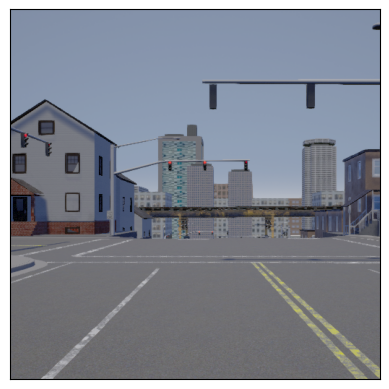

In [8]:
idx = random.randint(0, len(train_dataset))
img, lbl = train_dataset[0].values()
visualize_scene(img)

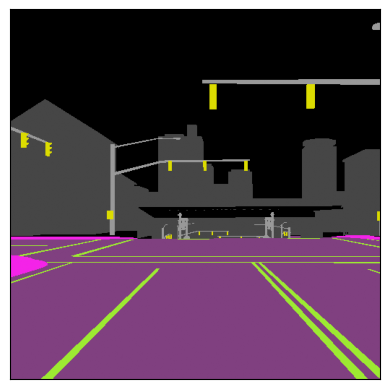

In [9]:
#visualize_annotation(lbl)

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def as_numpy(obj):
    if torch.is_tensor(obj):
        return obj.cpu().numpy()
    else:
        return np.array(obj)

In [12]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

def get_model(model_name, num_classes, weights_path = None):

    if "segformer" in model_name:
        processor = AutoImageProcessor.from_pretrained(model_name)
        model = SegformerForSemanticSegmentation.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True, semantic_loss_ignore_index = 13)
    elif "deeplabv3":
        processor = MobileViTImageProcessor.from_pretrained(model_name)
        model = MobileViTForSemanticSegmentation.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True, semantic_loss_ignore_index = 13)
    
    if weights_path:
        model.load_state_dict(torch.load(weights_path))
        
    model.to(DEVICE);
    
    return processor, model

In [13]:
class MeanIoU:
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/DeepLabV3Plus-Pytorch/metrics/stream_metrics.py
    """
    def __init__(self, n_classes= 13):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))
        
    def update(self, label_trues, logits):
        label_preds = torch.argmax(logits, dim=1)
        label_preds, label_trues = label_preds.cpu().numpy(), label_trues.cpu().numpy()
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist( lt.flatten(), lp.flatten())

    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.n_classes)
        hist = np.bincount(
            self.n_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.n_classes ** 2,
        ).reshape(self.n_classes, self.n_classes)
        return hist

    def get_results(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu, axis= 0)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return {
                "Overall Acc": acc,
                "Mean Acc": acc_cls,
                "FreqW Acc": fwavacc,
                "Mean IoU": mean_iu,
                "Class IoU": cls_iu,
            }


In [14]:
import sklearn.metrics as sk

def get_aupr(confs, seg_labels, out_label=13):

    aupr = []
    seg_labels = as_numpy(seg_labels)
    
    for conf, seg_label in zip(confs, seg_labels):

        out_label = out_label
        in_scores = - conf[np.where(seg_label == out_label)]
        out_scores  = - conf[np.where(seg_label != out_label)]
    
        if (len(out_scores) != 0) and (len(in_scores) != 0):
            
            pos = np.array(in_scores[:]).reshape((-1, 1))
            neg = np.array(out_scores[:]).reshape((-1, 1))
            examples = np.squeeze(np.vstack((pos, neg)))
            labels = np.zeros(len(examples), dtype=np.int32)
            labels[:len(pos)] += 1
        
            aupr.append(sk.average_precision_score(labels, examples))

        aupr = np.mean(aupr)
        return aupr * 100

In [15]:
from kornia.morphology import dilation, erosion
from scipy import ndimage as ndi

d_k1 = torch.zeros((1, 1, 2 * 1 + 1, 2 * 1 + 1)).cuda()
d_k2 = torch.zeros((1, 1, 2 * 2 + 1, 2 * 2 + 1)).cuda()
d_k3 = torch.zeros((1, 1, 2 * 3 + 1, 2 * 3 + 1)).cuda()
d_k4 = torch.zeros((1, 1, 2 * 4 + 1, 2 * 4 + 1)).cuda()
d_k5 = torch.zeros((1, 1, 2 * 5 + 1, 2 * 5 + 1)).cuda()
d_k6 = torch.zeros((1, 1, 2 * 6 + 1, 2 * 6 + 1)).cuda()
d_k7 = torch.zeros((1, 1, 2 * 7 + 1, 2 * 7 + 1)).cuda()
d_k8 = torch.zeros((1, 1, 2 * 8 + 1, 2 * 8 + 1)).cuda()
d_k9 = torch.zeros((1, 1, 2 * 9 + 1, 2 * 9 + 1)).cuda()

d_ks = {1: d_k1, 2: d_k2, 3: d_k3, 4: d_k4, 5: d_k5, 6: d_k6, 7: d_k7, 8: d_k8, 9: d_k9}


selem = torch.ones((3, 3)).cuda()
selem_dilation = torch.FloatTensor(ndi.generate_binary_structure(2, 1)).cuda()

for k, v in d_ks.items():
    v[:,:,k,k] = 1
    for i in range(k):
        v = dilation(v, selem_dilation)
    d_ks[k] = v.squeeze(0).squeeze(0)

def find_boundaries(labels):
    """
    Calculate boundary mask by getting diff of dilated and eroded prediction maps
    """
    assert len(labels.shape) == 4
    boundaries = (dilation(labels.float(), selem_dilation) != erosion(labels.float(), selem)).float()
    ### save_image(boundaries, f'boundaries_{boundaries.float().mean():.2f}.png', normalize=True)

    return boundaries

def expand_boundaries(boundaries, r=0):
    """
    Expand boundary maps with the rate of r
    """
    if r == 0:
        return boundaries
    expanded_boundaries = dilation(boundaries, d_ks[r])
    ### save_image(expanded_boundaries, f'expanded_boundaries_{r}_{boundaries.float().mean():.2f}.png', normalize=True)
    return expanded_boundaries

In [16]:
class BoundarySuppressionWithSmoothing(nn.Module):
    """
    Apply boundary suppression and dilated smoothing
    """
    def __init__(self, boundary_suppression=True, boundary_width=4, boundary_iteration=4,
                 dilated_smoothing=True, kernel_size=7, dilation=6):
        super(BoundarySuppressionWithSmoothing, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.boundary_suppression = boundary_suppression
        self.boundary_width = boundary_width
        self.boundary_iteration = boundary_iteration

        sigma = 1.0
        size = 7
        gaussian_kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
        gaussian_kernel /= np.sum(gaussian_kernel)
        gaussian_kernel = torch.Tensor(gaussian_kernel).unsqueeze(0).unsqueeze(0)
        self.dilated_smoothing = dilated_smoothing

        self.first_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, bias=False)
        self.first_conv.weight = torch.nn.Parameter(torch.ones_like((self.first_conv.weight)))

        self.second_conv = nn.Conv2d(1, 1, kernel_size=self.kernel_size, stride=1, dilation=self.dilation, bias=False)
        self.second_conv.weight = torch.nn.Parameter(gaussian_kernel)


    def forward(self, x, prediction=None):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x_size = x.size()
        # B x 1 x H x W
        assert len(x.shape) == 4
        out = x
        if self.boundary_suppression:
            # obtain the boundary map of width 2 by default
            # this can be calculated by the difference of dilation and erosion
            boundaries = find_boundaries(prediction.unsqueeze(1))
            expanded_boundaries = None
            if self.boundary_iteration != 0:
                assert self.boundary_width % self.boundary_iteration == 0
                diff = self.boundary_width // self.boundary_iteration
            for iteration in range(self.boundary_iteration):
                if len(out.shape) != 4:
                    out = out.unsqueeze(1)
                prev_out = out
                # if it is the last iteration or boundary width is zero
                if self.boundary_width == 0 or iteration == self.boundary_iteration - 1:
                    expansion_width = 0
                # reduce the expansion width for each iteration
                else:
                    expansion_width = self.boundary_width - diff * iteration - 1
                # expand the boundary obtained from the prediction (width of 2) by expansion rate
                expanded_boundaries = expand_boundaries(boundaries, r=expansion_width)
                # invert it so that we can obtain non-boundary mask
                non_boundary_mask = 1. * (expanded_boundaries == 0)

                f_size = 1
                num_pad = f_size

                # making boundary regions to 0
                x_masked = out * non_boundary_mask
                x_padded = nn.ReplicationPad2d(num_pad)(x_masked)

                non_boundary_mask_padded = nn.ReplicationPad2d(num_pad)(non_boundary_mask)

                # sum up the values in the receptive field
                y = self.first_conv(x_padded)
                # count non-boundary elements in the receptive field
                num_calced_elements = self.first_conv(non_boundary_mask_padded)
                num_calced_elements = num_calced_elements.long()

                # take an average by dividing y by count
                # if there is no non-boundary element in the receptive field,
                # keep the original value
                avg_y = torch.where((num_calced_elements == 0), prev_out, y / num_calced_elements)
                out = avg_y

                # update boundaries only
                out = torch.where((non_boundary_mask == 0), out, prev_out)
                del expanded_boundaries, non_boundary_mask

            # second stage; apply dilated smoothing
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)

            return out.squeeze(1)
        else:
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)
            else:
                out = x

        return out.squeeze(1)


In [17]:
class Trainer:
    def __init__(self,
                 #processor,
                 model: nn.Module,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 device: torch.device,
                 num_classes: int,
                 cfg: dict,
                 model_name: str,
                 resume_ckpt: dict = None,
                 
        ) -> None:
        
        self.model_name = model_name
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.patience = cfg["patience"]
        self.multi_scale = BoundarySuppressionWithSmoothing()
        self.multi_scale.to(DEVICE)
        #self.processor = processor
        
        if resume_ckpt:
            self.mean_iou = cfg['mean_iou']
            self.num_epochs = cfg["num_epochs"] - resume_ckpt['epoch']
            self.model = resume_ckpt['model_state_dict']
            self.optimizer = resume_ckpt['optimizer_state_dict']
            self.scheduler = resume_ckpt['scheduler_state_dict']

        else:
            self.mean_iou = 0.0
            self.num_epochs = cfg["num_epochs"]
            self.model = model.to(device)
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
            num_steps = self.num_epochs * len(train_loader)
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)

        self.step = 0
        self.best_acc = 0.0

        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

        wandb.init(name=cfg["run_name"], entity=WANDB_USER, project=WANDB_PROJECT, config=cfg)


    def train(self, verbose= False) -> None:
        for epoch in tqdm(range(self.num_epochs), desc="Epoch"):
            
            self.model.train()

            for batch in self.train_loader:
                imgs = batch['image'].to(self.device)
                labels = batch['labels'].to(self.device)
                '''imgs = self.processor(images=imgs, return_tensors="pt", do_resize=False, do_rescale=False).to(self.device)
                pred = self.model(**imgs)'''
                pred = self.model(imgs)
                logits = pred['out']
                #logits = F.interpolate(pred['out'], size=labels.shape[1:], mode='bilinear', align_corners=False)
                loss = F.cross_entropy(logits, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

            self.eval("train", epoch)
            self.eval("val", epoch)

            if self.patience < self.step:
                break


    @torch.no_grad()
    def eval(self, split: str, epoch: int) -> None:
        
        self.model.eval()

        loader = self.train_loader if split == "train" else self.val_loader
        
        mean_iou = MeanIoU()
        losses = []
        mean_avg = []
        std_avg = []
        
        for batch in loader:
            imgs = batch['image'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            '''imgs = self.processor(images=imgs, return_tensors="pt", do_resize=False, do_rescale=False).to(self.device)
            pred = self.model(**imgs)'''
            
            pred = self.model(imgs)
            logits = pred['out']
            #logits = F.interpolate(pred['out'], size=labels.shape[1:], mode='bilinear', align_corners=False)
            loss = F.cross_entropy(logits, labels)
            
            losses.append(loss.item())

            mean_iou.update(labels, logits)
        
        results = mean_iou.get_results()
        mean_iou = results['Mean IoU']
        loss = sum(losses) / len(losses)
        if split == "val":
            print(f"Epoch {epoch + 1} | {split.upper()} Metrics:")
            print(f"  Loss: {loss:.4f}")
            print(f"  Mean IoU: {mean_iou:.4f}\n")

            wandb.log({
            "epoch": epoch + 1,
            "val_loss": loss,
            "mean_iou": mean_iou,
        })

        if mean_iou > self.mean_iou and split == "val":
            self.mean_iou = mean_iou
            torch.save(self.model.state_dict(), self.ckpt_path/f"{self.model_name}.pt")
            torch.save({
                'epoch': epoch,
                'mean_iou': self.mean_iou,
                #'loss': loss,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                }, self.ckpt_path / "best_checkpoint")
            
            self.best_model = copy.deepcopy(self.model)
            self.step = 0

        elif split == "val":
            self.step += 1
    
    @torch.no_grad()
    def predict(self, loader, verbose= False):

        self.model.eval()
        mean_iou = MeanIoU()
        aupr = []

        mean_logit = []
        std_logit = []
        
        for batch in tqdm(loader):
            
            imgs = batch['image'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            '''imgs = self.processor(images=imgs, return_tensors="pt", do_resize=False, do_rescale=False).to(self.device)
            pred = self.model(**imgs)'''
            
            pred = self.model(imgs)
            logits = pred['out']
            #logits = F.interpolate(pred['out'], size=labels.shape[1:], mode='bilinear', align_corners=False)
            mean_iou.update(labels, logits)

            '''mean, std = get_mean_std(logits)
            mean_logit.append(mean)
            std_logit.append(std)
            return np.mean(mean_logit, axis = 0), np.mean(std_logit, axis = 0)'''

            """
            predictors
            """
            
            conf = maximum_softmax_probability(logits, self.multi_scale)
            #conf = max_logit(logits, self.multi_scale)
            #conf = euclidean_distance_sum(logits)
            
            '''conf = standardized_max_logit(logits, self.multi_scale,
                                          class_mean = MEAN_PER_CLASS, 
                                          class_var = VAR_PER_CLASS)'''

            conf = as_numpy(conf.squeeze(0).cpu())

            
            aupr.append(get_aupr(conf, labels))

        
        #pred_labels = pred_labels.cpu().numpy()
        return np.mean(aupr), mean_iou.get_results()

In [18]:
def get_mean_std(logits, num_classes = 13):

    mean_avg = np.zeros(13)
    std_avg = np.zeros(13)
    
    for logit in logits:
        conf, labels = torch.max(logit, 0)
        for c in range(num_classes):
            tens = torch.where(labels == c, conf, 0)
            mean, std = torch.std_mean(tens)

            mean_avg[c] += as_numpy(mean)
            std_avg[c] += as_numpy(std)

    return mean_avg, std_avg**2

In [19]:
def maximum_softmax_probability(logits, multi_scale = None):
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/anomaly/eval_ood_traditional.py#L185
    """
    conf, prediction  = torch.max(nn.functional.softmax(logits, dim=1),dim=1)

    #taken from standardized max logit
    if multi_scale:
        with torch.no_grad():
            conf = multi_scale(conf, prediction)
    
    return conf

In [20]:
def max_logit(logits, multi_scale = None):
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/anomaly/eval_ood_traditional.py#L185
    """
    conf, prediction  = torch.max(logits,dim=1)
    
    #taken from standardized max logit
    if multi_scale:
        with torch.no_grad():
            conf = multi_scale(conf, prediction)

    return conf

In [21]:
def standardized_max_logit(logits, multi_scale, class_mean, class_var, num_classes = 13):


    conf, prediction  = torch.max(logits,dim=1)
    for c in range(num_classes):
        conf = torch.where(
            prediction == c,
            (conf - class_mean[c]) / np.sqrt(class_var[c]),
            conf)

    if multi_scale:
        with torch.no_grad():
            conf = multi_scale(conf, prediction)

    return conf

In [22]:
def euclidean_distance_sum(logits):
    
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/anomaly/eval_ood_traditional.py#L185
    """

    def Normalization(x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))

    def Coefficient_map(x, thre):
        lamda = 50
        return 1 / (1 + np.exp(lamda * (x - thre)))
        
    dis_sum = torch.sum(logits,dim=1)
    dis_sum = - as_numpy(dis_sum.squeeze(0).cpu())
    dis_sum[dis_sum >= 400] = 400
    dis_sum = Normalization(dis_sum)
    prob_map = np.max(nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy(), axis=1)
    prob_map = Normalization(prob_map)
    Coefficient = Coefficient_map(dis_sum, 0.2)
    conf = Coefficient * dis_sum + (1 - Coefficient) * prob_map
    conf = dis_sum

    return conf

### mm-opensegmentation lab

### get the model

only specify the weights path if you do not want to train the model

In [29]:
#model_name = "apple/deeplabv3-mobilevit-small"
#model_name = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024" #results 0.61 on validation, but i have used 512, 512 img size, 1024, 1024 too big
model_name = "nvidia/segformer-b4-finetuned-ade-512-512"
#model_name = "nvidia/segformer-b2-finetuned-ade-512-512" #no-augmentation: (0,633 on val_set)


#weights_path = "/kaggle/input/weights/segformer_23_mln.pt"
weights_path = None

#processor, model = get_model(model_name, num_classes = len(COLORS)-1, weights_path = weights_path)
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
print(model.classifier[4])
model.classifier[4] = torch.nn.Conv2d(256, 13, kernel_size=(1, 1))
#model.aux_classifier[4] = nn.Identity()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))


In [30]:
for n, p in model.named_parameters():
    print(n)

backbone.conv1.weight
backbone.bn1.weight
backbone.bn1.bias
backbone.layer1.0.conv1.weight
backbone.layer1.0.bn1.weight
backbone.layer1.0.bn1.bias
backbone.layer1.0.conv2.weight
backbone.layer1.0.bn2.weight
backbone.layer1.0.bn2.bias
backbone.layer1.0.conv3.weight
backbone.layer1.0.bn3.weight
backbone.layer1.0.bn3.bias
backbone.layer1.0.downsample.0.weight
backbone.layer1.0.downsample.1.weight
backbone.layer1.0.downsample.1.bias
backbone.layer1.1.conv1.weight
backbone.layer1.1.bn1.weight
backbone.layer1.1.bn1.bias
backbone.layer1.1.conv2.weight
backbone.layer1.1.bn2.weight
backbone.layer1.1.bn2.bias
backbone.layer1.1.conv3.weight
backbone.layer1.1.bn3.weight
backbone.layer1.1.bn3.bias
backbone.layer1.2.conv1.weight
backbone.layer1.2.bn1.weight
backbone.layer1.2.bn1.bias
backbone.layer1.2.conv2.weight
backbone.layer1.2.bn2.weight
backbone.layer1.2.bn2.bias
backbone.layer1.2.conv3.weight
backbone.layer1.2.bn3.weight
backbone.layer1.2.bn3.bias
backbone.layer2.0.conv1.weight
backbone.layer

In [31]:
print(model.classifier[4])

Conv2d(256, 13, kernel_size=(1, 1), stride=(1, 1))


In [32]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"model trainable parameters before freezing are {trainable_params/1000000} milions")

model trainable parameters before freezing are 42.002018 milions


In [40]:
for name, param in model.backbone.named_parameters():
    param.requires_grad = False
for name, param in model.backbone.layer4.named_parameters():
    param.requires_grad = True
for name, param in model.classifier.named_parameters():
    param.requires_grad = True
for name, param in model.aux_classifier.named_parameters():
    param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"model trainable parameters are {trainable_params/1000000} milions")

model trainable parameters are 33.458722 milions


In [41]:
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_dl = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

### model training

In [42]:
cfg = {
    "num_epochs" : 100,
    "lr": 2e-4,
    "wd": 0.001,
    "patience": 10,
    "run_name": 'deeplabv3_resnet50_unfreezefromlayer4',
}

In [43]:
trainer = Trainer(
    #processor = processor,
    model= model,
    train_loader= train_dl,
    val_loader= val_dl ,
    device= DEVICE,
    num_classes = len(COLORS)-1,
    model_name = 'deeplabv3_resnet50_unfreezefromlayer4',
    cfg= cfg
)

In [44]:
MEAN_PER_CLASS = [1.72267947e+01, 7.66881425e+00, 5.77455433e-01, 4.47677614e-02,
 0.00000000e+00, 3.41044600e-01, 1.39990459e+00, 2.11263614e+01,
 7.31018189e+00, 7.46783295e+00, 1.15309967e-02, 2.41669891e+00,
 0.00000000e+00]
VAR_PER_CLASS = [1.33243940e+02, 1.53900278e+01, 2.14974713e-02, 3.87089461e-05,
 0.00000000e+00, 7.03953145e-03, 8.06856298e-02, 2.19127594e+02,
 5.62604913e+00, 8.48272837e+00, 1.52454267e-05, 8.70028476e-01,
 0.00000000e+00]

In [ ]:
trainer.train()

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
result = trainer.predict(val_dl)
#print(result[0])
print(result[1])

In [ ]:
result = trainer.predict(test_dl)
print(result[1])

In [ ]:
@torch.no_grad()
def get_predictions(img):
    img = img.unsqueeze(0).to(DEVICE)
    img = processor(images=img, return_tensors="pt", do_resize=False, do_rescale=False).to(DEVICE)
    '''pred = model(**img)
    log = F.interpolate(pred['logits'], size=(512, 512), mode='bilinear', align_corners=False)'''
    pred = self.model(imgs)
    log = pred['out']
    log = log.cpu()
    log = torch.argmax(log, dim=1)
    log = log.squeeze(0)
    return log

tst_idx = 1000
dataset = val_dataset
img = dataset[tst_idx]['image']
visualize_annotation(get_predictions(img))

In [ ]:
tst_idx = 500
dataset = val_dataset
img = dataset[tst_idx]['image']
visualize_annotation(get_predictions(img))

wandb.finish()

### AUPR Results:
- standardized max logit is the worst performer: 6.11 (if use boundiary suppression it goes up to 7.sth)
- max logit: 7.65
- maximum softmax probability: 11.33
- euclidean distance: 15.31

### TODO: should i compute mean iou after the computation of the anomaly scores (in this way mean iou changes after softmax etc).
### TODO: implement class AUPR